# Path Analysis in Dgraph Native and with Help From NetworkX

## The FoaF Graph
We'll use the Dgraph Stock Friend of a Friend (FoaF) graph for this example. It's a small (250 People and a few hundred Pets) graph of people and their friends. It's a consumable small graph that we use for training.

You can run the complete FoaF graph using Docker:

```
docker run --rm -p 8080:8080 -p 9080:9080 -p 8888:8888 ghcr.io/hypermodeinc/dgraph-foaf-graph:latest
```

Once started, you can run the following cells.

In [14]:
%pip install networkx
%pip install pydgraph
%pip install matplotlib

/opt/homebrew/Cellar/nvm/0.40.3/libexec/nvm.sh (line 1042): Unexpected ')' found, expecting '}'
    1) COLOR=$(nvm_print_color_code "$(echo "$COLORS" | awk '{ print substr($0, 1, 1); }')");;
     ^
from sourcing file /opt/homebrew/Cellar/nvm/0.40.3/libexec/nvm.sh
	called on line 3 of file /opt/homebrew/opt/nvm/nvm.sh
from sourcing file /opt/homebrew/opt/nvm/nvm.sh
	called on line 22 of file ~/.config/fish/config.fish
from sourcing file ~/.config/fish/config.fish
	called during startup
.: Error while reading file '/opt/homebrew/Cellar/nvm/0.40.3/libexec/nvm.sh'
fish: Unknown command: nvm
~/.config/fish/config.fish (line 23): 
nvm use default
^
from sourcing file ~/.config/fish/config.fish
	called during startup

[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: /Users/matthew/.pyenv/versions/3.12.7/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
/opt/homebrew/Cellar/nvm/0.40.3/libexec/nvm.sh (lin

In [87]:
# Import dependencies
import json
import pandas as pd
import pydgraph

In [89]:
# the host or IP addr where your Dgraph alpha service is running
dgraph_addr = "localhost"
# Dgraph DQL Client
client_stub = pydgraph.DgraphClientStub(addr='{}:9080'.format(dgraph_addr), options=[('grpc.max_receive_message_length', 1024*1024*1024)])
client = pydgraph.DgraphClient(client_stub)
print("pydgraph client, check version:", client.check_version())

pydgraph client, check version: v24.0.5


In [90]:
# Count the Person nodes, if this fails ensure you're running the FoaF graph (see above)
txn = client.txn(read_only=True)
query = """
query {
  count(func: type(Person)) {
      count(uid)
  }
}
"""
res = json.loads(txn.query(query=query).json)
print("Person nodes count:", res['count'][0]['count'])


Person nodes count: 250


# The FoaF graph
The FoaF graph is a small (250 persons and a few hundred pets) graph of people and their friends. It's a consumable small graph that we use for training. Note that only 200 of the 250 persons have Friend edges.

This graph shows `Person` nodes in the graph with 5 or more `friends`. Here's the query to generate it:

```gql
{
    all(func: type(Person)) @filter(gt(count(Person.friends), 5)) @recurse {
        uid
        name: Person.name
        f: Person.friends
    }
}
```

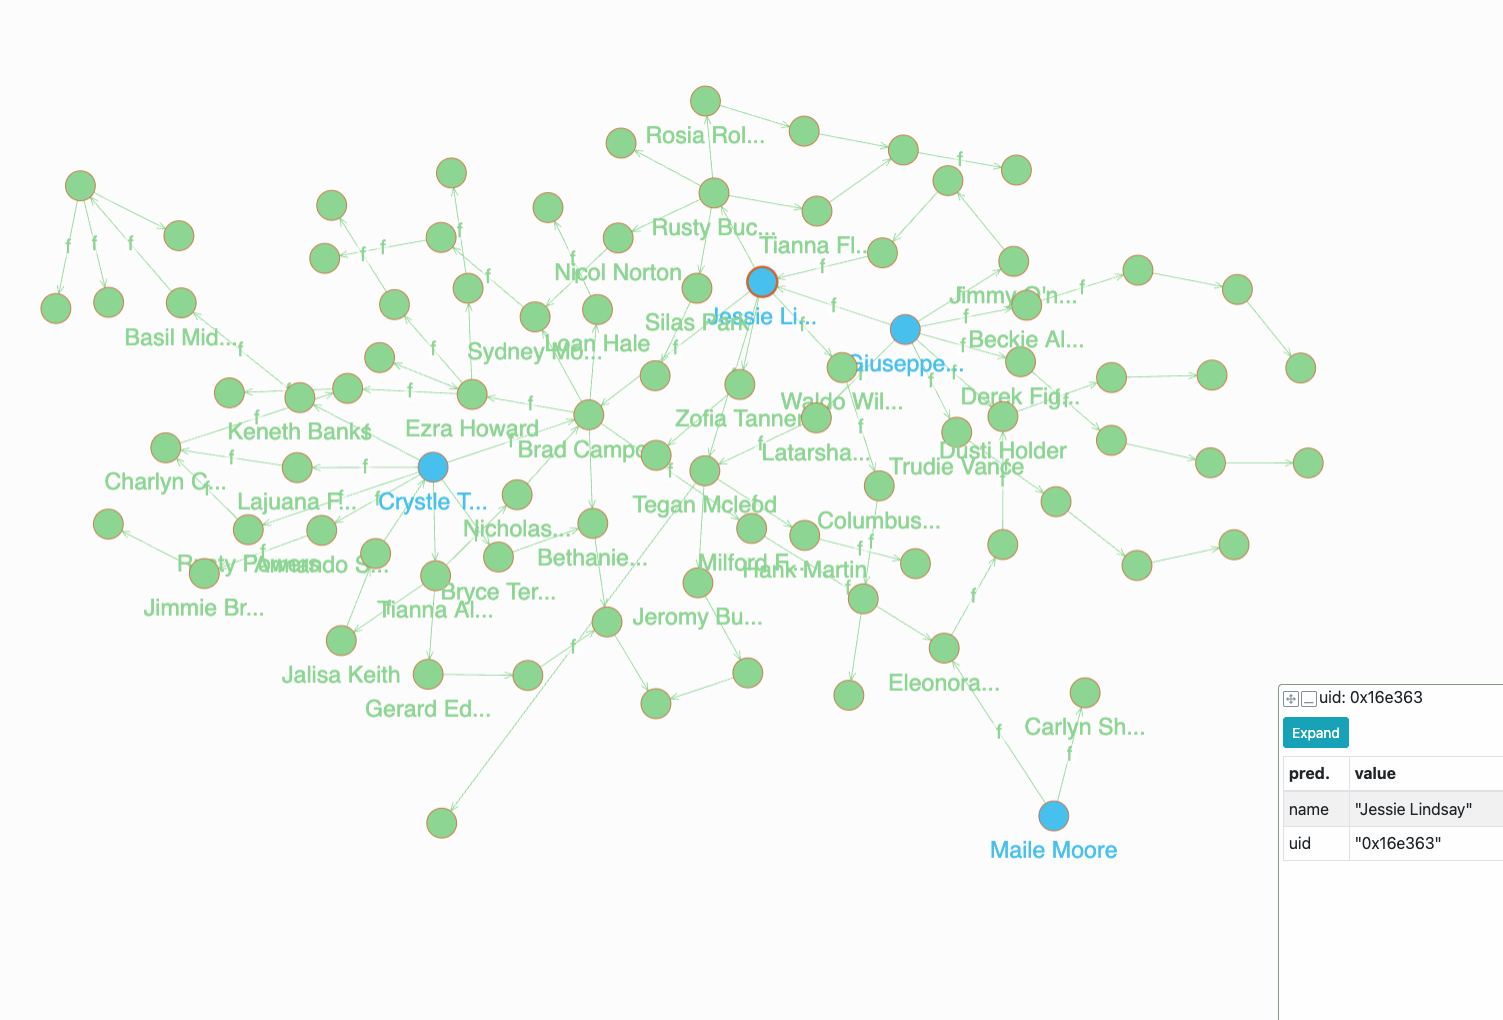

There are are a few highly central `People` in the graph, we'll focus on two going forward: "Giuseppe Sawyer" and "Jessie Lindsay". Giuseppe and Jessie are connected by three paths. A direct edge, a path of 4 degrees, and a path of 9 degrees.

We can learn this using the `numpaths` parameter to Dgraph's `shortest` path algorithm. Here's the query:

```gql
{
	var(func: eq(Person.name, "Giuseppe Sawyer")) {
		GUISEPPE as uid
	}

	var(func: eq(Person.name, "Jessie Lindsay")) {
		JESSIE as uid
	}
	
	PATH as shortest(from: uid(GUISEPPE), to: uid(JESSIE), numpaths: 10) {
		uid
		Person.friends
	}
	
	path(func: uid(PATH)) {
		uid
		Person.name
	}
}
```
This query not only returns the shortest path in the `path` block, but also returns the special `_path_` result, which contains all the paths that join Giuseppe and Jessie, up to 10.

```json
{
  "data": {
    "path": [
      {
        "uid": "0x2625a5",
        "Person.name": "Giuseppe Sawyer"
      },
      {
        "uid": "0x16e363",
        "Person.name": "Jessie Lindsay"
      }
    ],
    "_path_": [
      {
        "Person.friends": {
          "uid": "0x16e363"
        },
        "uid": "0x2625a5",
        "_weight_": 1
      },
      {
        "Person.friends": {
          "Person.friends": {
            "Person.friends": {
              "Person.friends": {
                "uid": "0x16e363"
              },
              "uid": "0x61a8c"
            },
            "uid": "0xdbba3"
          },
          "uid": "0x13d62a"
        },
        "uid": "0x2625a5",
        "_weight_": 4
      },
      {
        "Person.friends": {
          "Person.friends": {
            "Person.friends": {
              "Person.friends": {
                "Person.friends": {
                  "Person.friends": {
                    "Person.friends": {
                      "Person.friends": {
                        "Person.friends": {
                          "uid": "0x16e363"
                        },
                        "uid": "0x61a8c"
                      },
                      "uid": "0xdbba3"
                    },
                    "uid": "0x13d62a"
                  },
                  "uid": "0x1e8488"
                },
                "uid": "0x13d627"
              },
              "uid": "0x7a128"
            },
            "uid": "0x200b22"
          },
          "uid": "0x2932ec"
        },
        "uid": "0x2625a5",
        "_weight_": 9
      }
    ]
  },
  "extensions": {
    "server_latency": {
      "parsing_ns": 150416,
      "processing_ns": 9714751,
      "encoding_ns": 68167,
      "assign_timestamp_ns": 1436500,
      "total_ns": 11515083
    },
    "txn": {
      "start_ts": 1031
    },
    "metrics": {
      "num_uids": {
        "": 8,
        "Person.friends": 86,
        "Person.name": 2,
        "Person.pets": 2,
        "Pet.name": 0,
        "_total": 174,
        "uid": 76
      }
    }
  }
}
```

The DQL `shortest` is the only native path algorithm internal to Dgraph. For more complex path and other graph algorithms, you can use export queried DQL results and import them into the python NetworkX library. You may be asking, why not just add more graph analysis functions to Dgraph? This has been discussed in the past. There were a lot of factors that made it a non-starter, but the primary factor was that most graph analysis functions require the entire graph to be in memory, which for very large, distributed graphs is not a performant option.

## Using NetworkX with Dgraph

The Dgraph [pydgraph](https://github.com/hypermodeinc/pydgraph) package has a function to convert DQL results to a dictionary of nodes and a list of edges. This can be used to create a [NetworkX](https://networkx.org/) graph, which can then be used to perform more complex path analysis.

MultiDiGraph with 234 nodes and 284 edges


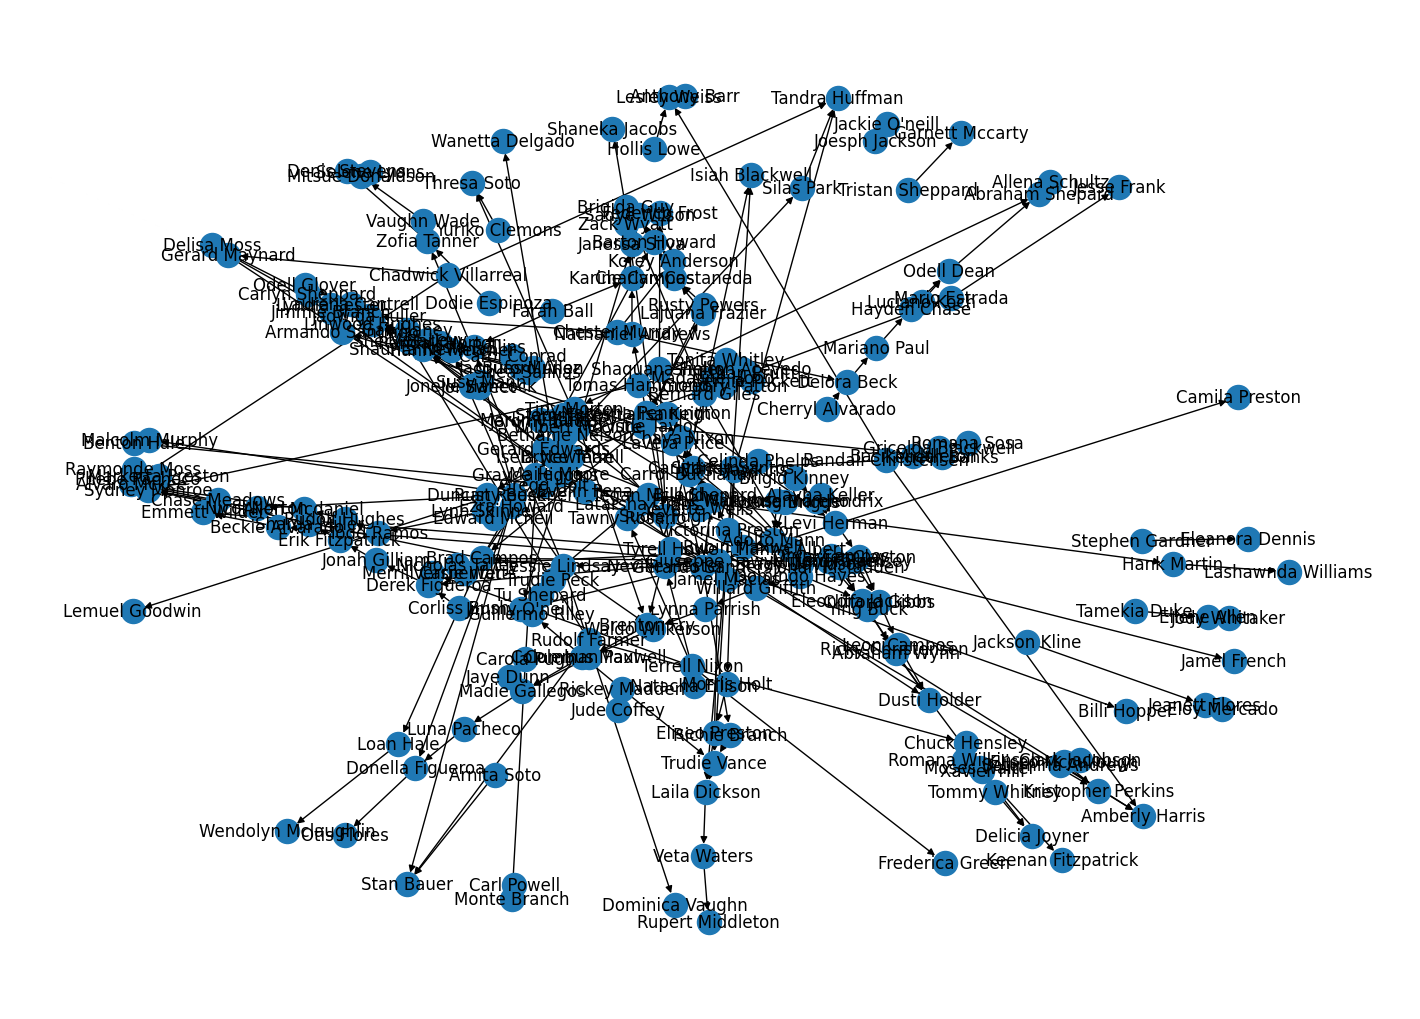

In [94]:
# Query all nodes the graph and build a NetworkX graph

import json
import networkx as nx
import matplotlib.pyplot as plt
from pydgraph import convert

all_nodes_query = """
{
	all(func: type(Person)) @recurse {
        id:uid
        name: Person.name
        friends: Person.friends
  }
}
"""
txn = client.txn(read_only=True)
res = txn.query(query=all_nodes_query)

nodes = {}
edges = []
# Here we use the pydgraph `convert function to extract nodes and edges from the DQL result
convert.extract_dict(nodes=nodes, edges=edges, data=json.loads(res.json))

nodes_df = pd.DataFrame.from_dict(nodes, orient = 'index')
edges_df = pd.DataFrame(edges)

G = nx.from_pandas_edgelist(
    edges_df,
    source="src",
    target="dst",
    create_using=nx.MultiDiGraph()
)
print(G)

# Create a mapping from node IDs to names (we'll use this to label the graph and below to show paths)
node_id_to_name = {}
for node_id in G.nodes():
    if node_id in nodes and 'name' in nodes[node_id]:
        node_id_to_name[node_id] = nodes[node_id]['name']
    else:
        node_id_to_name[node_id] = f"Node_{node_id}"  # Safe fallback
        
plt.figure(figsize=(14, 10))
nx.draw(G, with_labels=True, labels=node_id_to_name)
plt.show()


In [96]:
# Calclulate the shortest path between any two nodes in the graph

# Get the first source-target pair where source != target
first_source = None
first_target = None
first_path = None

for source, targets in nx.shortest_path(G).items():
    for target, path in targets.items():
        if source != target:  # Skip self-loops
            first_source = source
            first_target = target
            first_path = path
            break
    if first_source is not None:  # Found our first non-self connection
        break
    
# Convert IDs to names
source_name = node_id_to_name.get(first_source, first_source)
target_name = node_id_to_name.get(first_target, first_target)

print(f"First connection: {source_name} -> {target_name}")
print(f"Path: {' -> '.join([node_id_to_name.get(node_id, node_id) for node_id in first_path])}")
print(f"Path length: {len(first_path) - 1} edges")

First connection: Odell Glover -> Carlyn Sheppard
Path: Odell Glover -> Carlyn Sheppard
Path length: 1 edges


In [ ]:
# Calculate the longest shortest path
# Because this is a cyclic graph, we need to find the longest path explicitly, not with nx.dag_longest_path

longest_path = []
max_length = 0

for source, targets in nx.shortest_path(G).items():
    for target, path in targets.items():
        if len(path) > max_length:
            max_length = len(path)
            longest_path = path

print(f"Longest shortest path has {max_length} nodes ({max_length-1} edges)")


# Convert the path from IDs to names
path_names = [node_id_to_name.get(node_id, node_id) for node_id in longest_path]
print(f"Path with names: {' -> '.join(path_names)}")
print(f"Path with IDs: {' -> '.join(longest_path)}")



Longest shortest path has 23 nodes (22 edges)
Path with names: Maryrose Moreno -> Adolfo Mann -> Rubin Maxwell -> Victorina Preston -> Frank Williams -> Carlita Kim -> Chaya Nixon -> Jalisa Keith -> Nakesha Pennington -> Crystle Taylor -> Brad Campos -> Bethanie Nelson -> Stacy Estes -> Wilbert Mcclure -> Jimmy O'neill -> Tu Shepard -> Trudie Peck -> Jessie Lindsay -> Rusty Buckner -> Tianna Fletcher -> Linwood Hughes -> Lyndia Lester -> Carlyn Sheppard
Path with IDs: 0x1cfde6 -> 0x2932e8 -> 0x27ac49 -> 0x231865 -> 0x493e8 -> 0x1cfde4 -> 0x10c8ed -> 0x249f05 -> 0xf4244 -> 0x30d4e -> 0x19f0a8 -> 0x19f0a6 -> 0x7a127 -> 0x155cc7 -> 0xaae65 -> 0xdbba3 -> 0xaae64 -> 0x1b7742 -> 0x2625a6 -> 0x2932ed -> 0x186a4 -> 0x16e373 -> 0xf4247
